# Телеком — прогноз оттока клиентов

**Цель проекта** – разработать модель прогнозирования оттока клиентов (Churn prediction model). Модель должна быть готова через 2 недели. За это время необходимо провести исследование и разработать самостоятельно модель, написать отчет по исследованию. После этого модель пойдет в Production.

**Описание проекта:**  
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Отдел маркетинга провел исследование и выяснил, что в последнее время из нашей компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# План

1.  Загрузка данных и описание  
    1.1  Вывод  
2.  Предобработка данных  
    2.1  Проверка на пропуски  
    2.2  Изменение типов данных  
    2.3  Проверка на явные дубликаты  
    2.4  Проверка на аномалии  
    2.5  Вывод  
3.  Исследовательский анализ данных  
4.  Подготовка данных к обучению  
    4.1  Объединение таблиц в единый датасет  
    4.2  Обработка пропусков в новом датасете  
    4.3  Дополнительный анализ данных после объединения таблиц  
    4.4  Проверка на мультиколлинеарность  
    4.5  Pipeline предобработки  
    4.6  Вывод  
5.  Обучение моделей  
    5.1  CatBoostClassifier  
    5.2  LGBMClassifier  
    5.3  RandomForestClassifier  
    5.4  Выбор лучшей модели и ее тестирование  
6.  Отчет по результатам анализа

## Загрузка данных и описание

In [1]:
# импорт библиотек, дополняется по ходу проекта
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy.stats as stats

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_validate, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка данных
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')

In [3]:
# вывод информации по датасету contract
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


`customerID` - id номер клиента  
`BeginDate` - дата заключения договора  
`EndDate` - дата закрытия договора  
`Type` - тип договора  
`PaperlessBilling` - безбумажный счет  
`PaymentMethod` - метод оплаты  
`MonthlyCharges` - ежемесячное начисление  
`TotalCharges` - итоговое начисление  

In [4]:
# вывод информации по датасету personal
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков в таблице нет, тип данных соответствует.

`customerID` - id номер клиента  
`gender` - пол клиента  
`SeniorCitizen` - статус пенсионера  
`Partner` - женат/замужем  
`Dependents` - наличие иждивенцев  

In [5]:
# вывод информации по датасету internet
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков в таблице нет, тип данных соответствует.

`customerID` - id номер клиента  
`InternetService` - тип подключения к интернету  
`OnlineSecurity` - наличие блокировки небезопасных сайтов  
`OnlineBackup` - наличие облачного хранилища  
`DeviceProtection` - наличие антивирусного ПО  
`TechSupport` - наличие выделенной линии поддержки  
`StreamingTV` - наличие стримингового ТВ  
`StreamingMovies` - наличие каталога фильмов  

In [6]:
# вывод информации по датасету phone
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков в таблице нет, тип данных соответствует.

`customerID` - id номер клиента  
`MultipleLines` - несколько линий 

### Вывод

Таблицы имеют неверные типы данных, например: BeginDate должен иметь тип данных date, но он имеет текстовый тип. TotalCharges должен диметь тип данных float, а имеет так же текстовый тип. Названия столбцов не соответствуют принятому стилю, но менять мы их не будем.
Далее в предобработке данных мы все исправим.

## Предобработка данных

### Проверка на пропуски

Для начала проверим таблицу contract. Ранее мы указывали, что столбец TotalCharges имеет неверный тип данных - текстовый, проверим его на пропуски данных, отсортировавв от большего к меньшему.

In [7]:
contract.TotalCharges.sort_values()

936           
3826          
4380          
753           
5218          
         ...  
6646    997.75
5598     998.1
3686    999.45
3353     999.8
2845     999.9
Name: TotalCharges, Length: 7043, dtype: object

Как видим есть пропуски, которые невозможно определить классическим способом isna(). Заменим их на нули, т.к. далее потребуется изменить тип данных на float, иначе тип данных изменить не получится.

In [8]:
contract.TotalCharges = contract.TotalCharges.replace(' ', '0')

In [9]:
# выведем записи где итоговый платеж равен 0
contract.query('TotalCharges == "0"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


Нули в поле объяснимы тем, что договор был заключен 01-02-2020 (данные нам предоставлены ровно до этой даты) соответственно накопительного итога нет.

Так же есть пропуски в поле EndDate, они объяснимы тем, что договор еще не закрыт и вместо привычного Nan стоит значение No. Так же заменим данные на No, чтобы затем изменить тип на дату. Но предварительно добавим целевой признак, который указывает ушел клиент или нет.

In [10]:
contract['target'] = np.where(contract['EndDate'] == 'No', 0, 1).astype('int')
# заменим на дату 2020-02-01, т.к. на моменрт выгрузки мы знаем, что этот клиент с нами
contract.loc[contract['EndDate'] == 'No','EndDate'] = '2020-02-01'

### Изменение типов данных

Ранее мы выяснили, что данные имеют неверные типы данных, приведем их в соответствие.

In [11]:
# изменим тип  данных у таблицы contract
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


### Проверка на явные дубликаты

In [13]:
print('Доля явных дубликатов в датасете contract', contract.duplicated().mean())
print('Доля явных дубликатов в датасете personal', personal.duplicated().mean())
print('Доля явных дубликатов в датасете internet', internet.duplicated().mean())
print('Доля явных дубликатов в датасете phone', phone.duplicated().mean())

Доля явных дубликатов в датасете contract 0.0
Доля явных дубликатов в датасете personal 0.0
Доля явных дубликатов в датасете internet 0.0
Доля явных дубликатов в датасете phone 0.0


Явных дубликатов не обнаружено в данных.

### Проверка на аномалии

На аномалии можно проверить только таблицу contract.

In [14]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
target,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


In [15]:
def boxplot_table(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');

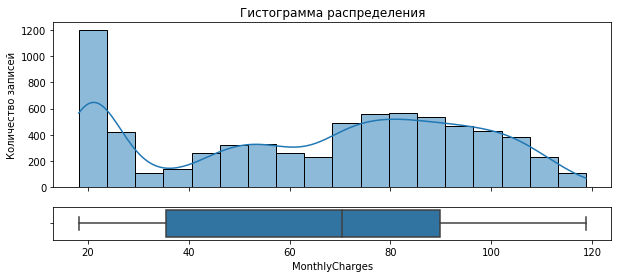

In [16]:
boxplot_table(contract, 'MonthlyCharges')

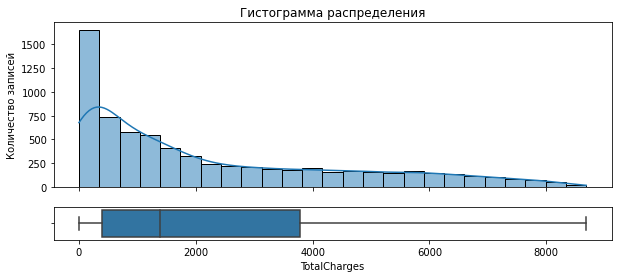

In [17]:
boxplot_table(contract, 'TotalCharges')

Аномалиии и выбросы в данных не обнаружены. Распределение данных ненормальное. По полю TotalCharges данные имеют длинный правый хвост.

### Вывод

Мы обработали пропуски, изменили тип данных у полей в таблице contract. Проверили данные на дубликаты и аномалии, они обнаружены не были. Так же почти все поля в предоставленных таблицах в логике могут быть бинарными, исправлять не стали, но возможно в будущем потребуется заменить на 1 и 0 для обучения моделей. Данные готовы к исследовательскому анализу анализу.

## Исследовательский анализ данных

Проведем короткий анализ данных.  

Для анализа создам копию таблицы contract, т.к. придется часть данных добавить, исходный датасет менять не будем.

In [18]:
df = contract.copy()

In [19]:
# добавим поля  month и year
df['begin_month'] = df['BeginDate'].dt.month
df['begin_year'] = df['BeginDate'].dt.year
df['end_month'] = df['EndDate'].dt.month
df['end_year'] = df['EndDate'].dt.year
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,begin_month,begin_year,end_month,end_year
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,2020,2,2020
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,4,2017,2,2020
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,10,2019,12,2019
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,5,2016,2,2020
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,9,2019,11,2019


In [20]:
print('Доля ушедших клиентов', len(df.query('target == 1'))/len(df))

Доля ушедших клиентов 0.2653698707936959


Имеем дисбаланс классов, при обучении  моделей это нужно учесть.

Посмотрим в какой год было заключено больше всего контрактов.

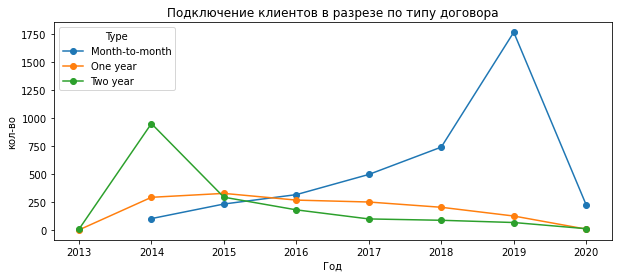

In [21]:
(df.pivot_table(index='Type', columns='begin_year', values='customerID', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Подключение клиентов в разрезе по типу договора')
plt.xlabel('Год')
plt.ylabel('кол-во');

Договоров с типом "Month-to-month" от года к году заключается больше, 2020 год можно не смотреть данные неполные.  
Проверим по какому типу договора больше выручка.

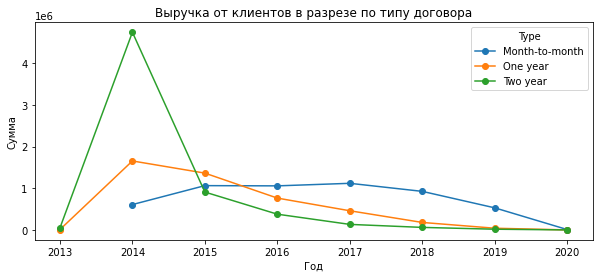

In [22]:
(df.pivot_table(index='Type', columns='begin_year', values='TotalCharges', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Выручка от клиентов в разрезе по типу договора')
plt.xlabel('Год')
plt.ylabel('Сумма');

Более менее стабильная выручка по типу договора "Month-to-month", но в целом она снижается по всем типам договоров от года к году, возможно это связано с уменьшением ежемесячного начисления.

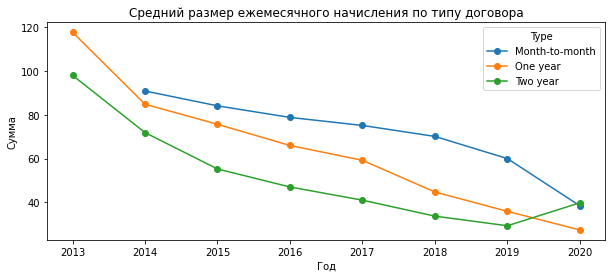

In [23]:
(df.pivot_table(index='Type', columns='begin_year', values='MonthlyCharges', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средний размер ежемесячного начисления по типу договора')
plt.xlabel('Год')
plt.ylabel('Сумма');

Как мы видим средние ежемесячные начисления действительно уменьшаются от года к году. Это может быть связано с высокой конкурентностью на рынке и удешевлением предоставляемых услугм за счет внедрения новых технологий в коммуникации.

Проверим самые пиковые месяцы по подключению новых клиентов.

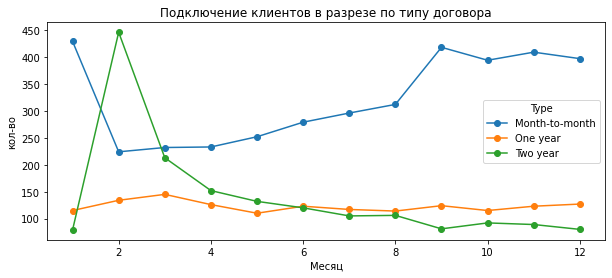

In [24]:
(df.pivot_table(index='Type', columns='begin_month', values='customerID', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Подключение клиентов в разрезе по типу договора')
plt.xlabel('Месяц')
plt.ylabel('кол-во');

Какой-то закономерности исходя из времени года выявить не удалось, те пики что мы видим связаны с подключение новых клиентов и ранее мы видели, что пик пришелся на 2014 и 2019 годы.

Првоерим в какие года пришелся самыйц большой отток клиентов, так же посмотрим отток внутри года, попытаемся выявить закономерность.

In [25]:
(df.query('end_year <= 2020 and target==1')
 .pivot_table(index='Type', columns='end_year', values='customerID', aggfunc='count').T
)

Type,Month-to-month,One year,Two year
end_year,,,
2019,1242,129,38
2020,413,37,10


Основной отток пришелся на 2019 год, при чем по клиентам, с которыми был заключен договор типа "Month-to-month", как мы помним и основная масса клиентов была подключена в этот же год и по этому же типу договора.

In [26]:
a = df.pivot_table(index='Type', values='customerID', aggfunc='count').T
b = df.query('end_year <= 2020 and target==1').pivot_table(index='Type', values='customerID', aggfunc='count').T
pd.concat([a, b], join="inner").reset_index()

Type,index,Month-to-month,One year,Two year
0,customerID,3875,1473,1695
1,customerID,1655,166,48


По данным за весь период самую большую долю оттока имеют контракты с типом "Month-to-month".

Проверим пиковые месяцы по оттоку клиентов в 2019 году.

In [27]:
(df.query('end_year < 2020 and target==1')
 .pivot_table(index='Type', columns='end_month', values='customerID', aggfunc='count')
 .T
)

Type,Month-to-month,One year,Two year
end_month,,,
10,394,56,8
11,429,39,17
12,419,34,13


Что-то явно изменилось в политике продаж в 2019 году в сентябре-октябре, т.к. пик подключений пришелся на этот период, но так же и клиенты начали уходить начиная с этих дат.

Для более глубокого анализа требуется объеденить наши таблицы и посмотреть данные в других разрезах. Например кто чаще подключался, женщины, мужчины? Или кто закрывал договор обслуживания, какие услуги пользовались популярностью? Возможно из-за появления какой-то услуги и произошли пики в 2019 году.

## Подготовка данных к обучению

### Объедениение таблиц в единый датасет

In [28]:
# объеденим таблицы
# заменим индексы в таблицах для объединения
# инидексы потом сбросим
df = (contract.set_index('customerID')
      .join([internet.set_index('customerID'), personal.set_index('customerID'), phone.set_index('customerID')]
            , how='left')
      .reset_index()
     )
# приведем названия столбцов к нижнему регистру для удобной работы
df.columns = df.columns.str.lower()
# выведем общую информацию по полученному датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   internetservice   5517 non-null   object        
 10  onlinesecurity    5517 non-null   object        
 11  onlinebackup      5517 non-null   object        
 12  deviceprotection  5517 non-null   object        
 13  techsupport       5517 non-null   object        
 14  streamingtv       5517 n

In [29]:
df.sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
4246,5153-LXKDT,2014-06-01,2020-02-01,Two year,Yes,Electronic check,110.20,7467.50,0,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes
5484,4419-UJMUS,2014-05-01,2020-02-01,Two year,Yes,Electronic check,99.35,6856.45,0,Fiber optic,No,No,No,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
4705,5760-FXFVO,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,78.95,494.95,0,Fiber optic,Yes,Yes,No,No,No,No,Male,0,No,No,No
312,1557-EMYVT,2016-07-01,2020-02-01,Two year,No,Credit card (automatic),115.05,4895.10,0,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,No,No,Yes
2537,8670-ERCJH,2014-02-01,2020-02-01,Two year,No,Bank transfer (automatic),113.40,8164.10,0,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,No,No,Yes


Признак seniorcitizen все-таки является категориальным, поэтому заменим на тип данных object.

In [30]:
df['seniorcitizen'] = df['seniorcitizen'].astype('object')

In [31]:
# добавим признак duration - длительность контракта в днях
df['duration'] = (df['enddate'] - df['begindate']).astype('timedelta64[D]')
df['duration'] = df['duration'].astype('int64')

### Обработка пропусков в новом датасете
У нас есть пропуски, т.к. таблицы были разнородные, с различным количеством строк. 

In [32]:
df.isna().mean().sort_values(ascending=False).to_frame('Nan').query('Nan > 0')

,Nan
onlinebackup,0.216669
deviceprotection,0.216669
streamingmovies,0.216669
streamingtv,0.216669
internetservice,0.216669
onlinesecurity,0.216669
techsupport,0.216669
multiplelines,0.096834


Отсутствие записи равно отсутсвие услуги, соответственнно пропуски мы сможем заменить на значения No.

In [33]:
# создадим список с колонками, где есть пропуски
cols = ['onlinesecurity', 'techsupport', 'internetservice', 'onlinebackup', 
        'deviceprotection', 'streamingmovies', 'streamingtv', 'multiplelines']
# заменим пропуски на No
df[cols] = df[cols].fillna('No')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   internetservice   7043 non-null   object        
 10  onlinesecurity    7043 non-null   object        
 11  onlinebackup      7043 non-null   object        
 12  deviceprotection  7043 non-null   object        
 13  techsupport       7043 non-null   object        
 14  streamingtv       7043 n

Для обучения нам не потребуется признак customerid, удалим его. Так же удалим признаки begindate и enddate, чтобы не получить утечки данных при обучении, т.к. у нас есть признак duration.

In [35]:
df.drop(['customerid', 'begindate', 'enddate'], inplace=True, axis=1)

### Дополнительный анализ данных после объединения таблиц

Проверим какие платежи совершали клиенты, которые уходили. Для этого введем еще один признак (потом его удалим), который разобъет наших клиентов на несколько подгрупп исходя из их счетов.

In [36]:
df['charges_group'] = pd.cut(df['monthlycharges'],
                               bins=[0., 20., 40., 60., 80., np.inf])

In [37]:
# напишем функцию для меньшего написания кода в дальнейшем
# получим таблицу, где будет кол-во ушедших клиентов, всего клиентов и доля ушедших
def result_table(data, column):
    table = (data.groupby(column)['target'].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table

In [38]:
result_table(df, 'charges_group')

,sum,count,share
charges_group,,,
"(80.0, inf]",906,2666,0.339835
"(60.0, 80.0]",473,1459,0.324195
"(40.0, 60.0]",276,1080,0.255556
"(20.0, 40.0]",156,1182,0.131980
"(0.0, 20.0]",58,656,0.088415


In [39]:
df.drop(['charges_group'], inplace=True, axis=1)

Чем больше пользователи платят в месяц - тем выше вероятность ухода, иными словами - уходят наиболее прибыльные клиенты по неизвестной причине

In [40]:
# выведем средние ежемесячные платежи по клиентам
df.groupby('target')['monthlycharges'].agg('mean')

target
0    61.265124
1    74.441332
Name: monthlycharges, dtype: float64

Сформулируем Гипотезы о равенстве средних двух генеральных совокупностей.

**H0 (нулевая гипотеза)**: Средние ежемесячные платежи ушедших и оставшихся клиентов равны.

**H1 (альтернативная гипотеза)**: Средние ежемесячные платежи ушедших и оставшихся клиентов не равны.

In [41]:
df_deflux = df.query('target == 1')
df_not_deflux = df.query('target == 0')

sample_1 = df_deflux['monthlycharges'][df_deflux['monthlycharges'].notna()].tolist()
sample_2 = df_not_deflux['monthlycharges'][df_not_deflux['monthlycharges'].notna()].tolist()
alpha = .05
_, p = stats.levene(sample_1, sample_2)

if p < alpha:
    print('Отвергаем Н0, дисперсии различаются')
else:
    print('Не отвергаем Н0, дисперсии не различаются')
print('p-value:', p)
print('Дисперсии по выборкам: ', [np.var(x, ddof=1) for x in [sample_1, sample_2]])

Отвергаем Н0, дисперсии различаются
p-value: 1.0261244899421871e-78
Дисперсии по выборкам:  [608.4141833954307, 966.7527670734264]


In [42]:
alpha = .05 
results = stats.mannwhitneyu(sample_1, sample_2, alternative='two-sided')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем Н0")
else:
    print("Не отвергаем Н0")

p-value: 3.311627651988585e-54
Отвергаем Н0


По результатам проведенных тестов делаем вывод, средние ежемесячные платежи ушедших и оставшихся клиентов не равны.
И клиенты, которые уходят получают счета выше.

Проверим доли оттока пользователей исходя из категориальных признаков, которые есть в наших данных. Составим портрет клиента, который уходит.

In [43]:
object_columns = set(df.select_dtypes(include=['object']).columns) - set(['type', 'target'])
for col in object_columns:
    display(result_table(df, col))

,sum,count,share
paperlessbilling,,,
Yes,1400,4171,0.335651
No,469,2872,0.163301


,sum,count,share
partner,,,
No,1200,3641,0.329580
Yes,669,3402,0.196649


,sum,count,share
onlinebackup,,,
No,1346,4614,0.291721
Yes,523,2429,0.215315


,sum,count,share
internetservice,,,
Fiber optic,1297,3096,0.418928
DSL,459,2421,0.189591
No,113,1526,0.074050


,sum,count,share
seniorcitizen,,,
1,476,1142,0.416813
0,1393,5901,0.236062


,sum,count,share
deviceprotection,,,
No,1324,4621,0.286518
Yes,545,2422,0.225021


,sum,count,share
dependents,,,
No,1543,4933,0.312791
Yes,326,2110,0.154502


,sum,count,share
gender,,,
Female,939,3488,0.269209
Male,930,3555,0.261603


,sum,count,share
onlinesecurity,,,
No,1574,5024,0.313296
Yes,295,2019,0.146112


,sum,count,share
streamingtv,,,
Yes,814,2707,0.300702
No,1055,4336,0.243312


,sum,count,share
streamingmovies,,,
Yes,818,2732,0.299414
No,1051,4311,0.243795


,sum,count,share
multiplelines,,,
Yes,850,2971,0.286099
No,1019,4072,0.250246


,sum,count,share
techsupport,,,
No,1559,4999,0.311862
Yes,310,2044,0.151663


,sum,count,share
paymentmethod,,,
Electronic check,1071,2365,0.452854
Mailed check,308,1612,0.191067
Bank transfer (automatic),258,1544,0.167098
Credit card (automatic),232,1522,0.152431


**Портрет ушедшего клиента:**  
- Не имеет иждевенцев  
- Холост/не замужем  
- Имеет статус пенсионера  
- Не пользуется блокировками небезопасных сайтов  
- Не имеет выделенной линии поддержки  
- Не пользуется облачным хранилищем  
- Не использует антивирусное ПО  
- Нет разницы по половому признаку  
- Пользуется интренет-соединением типа оптоволокно  
- Пользуется электронными чеками

### Проверка на мультиколлинеарность

Проверим мультиколлинеарность между нашими численными данными. Если значение будет превышать 0.8 избавимся от признаков, чтобы улучшить обобщение. Воспользуемся Корреляцией Пирсона. Также проверим взаимную информацию категориальных признаков.

In [44]:
df[['monthlycharges', 'totalcharges', 'duration']].corr().style.background_gradient(low=0.1, cmap='YlOrRd')

,monthlycharges,totalcharges,duration
monthlycharges,1.000000,0.651174,0.247754
totalcharges,0.651174,1.000000,0.826109
duration,0.247754,0.826109,1.000000


Сильная корреляция наблюдается по двум признакам duration и totalcharges, удалим totalcharges.

In [45]:
df.drop(['totalcharges'], inplace=True, axis=1)

Переведем наши категориальные признаки к целочисленным с помощью кодирования.

In [46]:
# создадим копию
X = df.copy()
y = X.pop('target')
# проведем преобразование
for col in list(X.select_dtypes(include=['object', 'category']).columns):
    X[col], _ = X[col].factorize()

In [47]:
scores = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values(ascending=False)
scores.to_frame('scores').style.background_gradient(low=0.1, cmap='YlOrRd')

,scores
duration,0.323944
type,0.096535
internetservice,0.054604
monthlycharges,0.050183
paymentmethod,0.049559
paperlessbilling,0.030015
dependents,0.020263
onlinesecurity,0.019517
partner,0.011267
seniorcitizen,0.010109


Больше всего информации о целевом признаке содержится в duration, не так значительно, чтобы удалять из обучения признак. Признак duration будет определять целевой признак. Признак totalcharges был удален.

### Pipeline предобработки

Pipeline будет состоять из следующих компонентов:

* StandardScaler для числовых признаков  
* OrdinalEncoder для порядковых признаков  
* OneHotEncoder для бинарных признаков  

In [48]:
def make_X_y():
    features, target = df.copy().drop(columns=['target'], axis=1), df.copy()['target']
    return train_test_split(features, target, test_size=0.25, random_state=311022, stratify=target)

In [49]:
X_train, X_test, y_train, y_test = make_X_y()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [50]:
numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = ['paymentmethod', 'type', 'internetservice', 'gender']
binary_features = list(set(list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)) - set(cat_features))

In [51]:
def make_df(X):
    cols = (numeric_features + cat_features + binary_features)
    X = pd.DataFrame(X, columns=cols)
    return X 

In [52]:
processor = ColumnTransformer(transformers = [('std_scaler', StandardScaler(), numeric_features),
                                                 ('cat', OrdinalEncoder(), cat_features),
                                                 ('binary', OneHotEncoder(drop='first'), binary_features)])

pl = Pipeline(steps = [('processor', processor),
                       ('make_df', FunctionTransformer(make_df, validate=False))])

Проверим Pipeline.

In [53]:
X_train_pl = pl.fit_transform(X_train)

In [54]:
X_train_pl.shape

(5282, 17)

In [55]:
X_train_pl.head()

,monthlycharges,duration,paymentmethod,type,internetservice,gender,paperlessbilling,partner,onlinebackup,seniorcitizen,deviceprotection,dependents,onlinesecurity,streamingtv,streamingmovies,multiplelines,techsupport
0,1.456984,1.569756,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,-0.833547,-1.276000,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.674090,-0.624014,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.358984,1.410768,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,1.337391,-1.193165,2.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


Получили преобразованный DataFrame. Можем приступать к подготовке моделей. 

Создадим вспомогательные списки, в которые будем сохранять метрики по моделям, понадобится для подготовки отчета.

In [62]:
roc_auc = []
best_params = []
model_name = []

### Вывод

Мы объедениили наши таблицы в единый датасет, обработали пропуски, заменили тип данных, где потребовалось, провели дополнительный анализ с проверкой гипотез. Получили портрет клиента, который уходит.

**Портрет ушедшего клиента:**  
- Не имеет иждевенцев  
- Холост/не замужем  
- Имеет статус пенсионера  
- Не пользуется блокировками небезопасных сайтов  
- Не имеет выделенной линии поддержки  
- Не пользуется облачным хранилищем  
- Не использует антивирусное ПО  
- Нет разницы по половому признаку  
- Пользуется интренет-соединением типа оптоволокно  

Выполнили проверку на мультиколлинеарность.

У нас наблюдается дисбаланс классов, мы это видели в исследовательском анализе. Это нужно учесть в будущем при обучении наших моделей.  
Применили StandardScaler для количественных признаков, для того чтобы придать им одинаковый масштаб.  
Для категориальных признаков применили OrdinalEncoder.  

## Обучение моделей

In [57]:
# зададим константу
random_state = 311022

Однозначно бустинговые модели будут выдавать лучше результаты, поэтому обучим пару бустинговых моделей, а так же посмотрим на случайный лес.

### CatBoostClassifier

In [58]:
X_train_cbc, X_test_cbc, y_train_cbc, y_test_cbc = make_X_y()
category_X = list(X_train_cbc.select_dtypes(include=['object', 'category']))

In [59]:
cbc = CatBoostClassifier(loss_function='Logloss', random_state=random_state)
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=random_state)
parameters = {'depth': range(4,13,4),
              'learning_rate': [0.01, 0.1],
              'iterations': range(200,601,200)
             }
Grid_CBC = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
Grid_CBC.fit(X_train_cbc, y_train_cbc, cat_features=category_X, verbose=100)

0:	learn: 0.6857815	total: 56.2ms	remaining: 11.2s
100:	learn: 0.4200291	total: 738ms	remaining: 724ms
199:	learn: 0.3723667	total: 1.43s	remaining: 0us
0:	learn: 0.6863172	total: 7.26ms	remaining: 1.44s
100:	learn: 0.4284496	total: 668ms	remaining: 655ms
199:	learn: 0.3817390	total: 1.44s	remaining: 0us
0:	learn: 0.6860088	total: 7.84ms	remaining: 1.56s
100:	learn: 0.4205492	total: 651ms	remaining: 639ms
199:	learn: 0.3777324	total: 1.38s	remaining: 0us
0:	learn: 0.6862901	total: 7.8ms	remaining: 1.55s
100:	learn: 0.4239347	total: 700ms	remaining: 686ms
199:	learn: 0.3776991	total: 1.36s	remaining: 0us
0:	learn: 0.6862124	total: 7.14ms	remaining: 1.42s
100:	learn: 0.4219424	total: 637ms	remaining: 625ms
199:	learn: 0.3766510	total: 1.35s	remaining: 0us
0:	learn: 0.6252094	total: 7.29ms	remaining: 2.91s
100:	learn: 0.1839637	total: 4.36s	remaining: 12.9s
200:	learn: 0.0958351	total: 10.9s	remaining: 10.8s
300:	learn: 0.0582459	total: 18s	remaining: 5.92s
399:	learn: 0.0419722	total: 24

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=311022, test_size=0.25, train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f08ccc3f550>,
                   param_distributions={'depth': range(4, 13, 4),
                                        'iterations': range(200, 601, 200),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [63]:
best_score = Grid_CBC.best_score_ 
estimator_cbc = Grid_CBC.best_estimator_

In [64]:
roc_auc.append(best_score)
best_params.append(Grid_CBC.best_params_)
model_name.append('CatBoostClassifier CV')

### LGBMClassifier

LGBM работает лучше и быстрее без Ohe и Ordinal кодирования. Поэтому преобразуем наши выборки для LGBM, переведем все в category кроме числовых.

In [65]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = make_X_y()
X_train_lgbm.shape, X_test_lgbm.shape, y_train_lgbm.shape, y_test_lgbm.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [70]:
category_X_lgbm = list(X_train_lgbm.select_dtypes(include=['object', 'category']))
X_train_lgbm[category_X_lgbm] = (X_train_lgbm[category_X_lgbm].apply(lambda x: x.astype('category')))
X_test_lgbm[category_X_lgbm] = (X_test_lgbm[category_X_lgbm].apply(lambda x: x.astype('category')))

In [71]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3040 to 2903
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type              5282 non-null   category
 1   paperlessbilling  5282 non-null   category
 2   paymentmethod     5282 non-null   category
 3   monthlycharges    5282 non-null   float64 
 4   internetservice   5282 non-null   category
 5   onlinesecurity    5282 non-null   category
 6   onlinebackup      5282 non-null   category
 7   deviceprotection  5282 non-null   category
 8   techsupport       5282 non-null   category
 9   streamingtv       5282 non-null   category
 10  streamingmovies   5282 non-null   category
 11  gender            5282 non-null   category
 12  seniorcitizen     5282 non-null   category
 13  partner           5282 non-null   category
 14  dependents        5282 non-null   category
 15  multiplelines     5282 non-null   category
 16  duration          528

In [72]:
lgbm = LGBMClassifier(random_state=random_state, class_weight = 'balanced')

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=random_state)
params = {'n_estimators': range(100, 501, 100),
          'learning_rate': [0.01, 0.1, 1.0],
          'max_depth': range(5, 8, 1),
          'num_leaves': [32, 64, 128]}

grid_cv = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_lgbm, y_train_lgbm)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=311022, test_size=0.25, train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=311022),
                   param_distributions={'learning_rate': [0.01, 0.1, 1.0],
                                        'max_depth': range(5, 8),
                                        'n_estimators': range(100, 501, 100),
                                        'num_leaves': [32, 64, 128]},
                   scoring='roc_auc')

In [73]:
best_score = grid_cv.best_score_ 
estimator_lgbm = grid_cv.best_estimator_

In [74]:
roc_auc.append(best_score)
best_params.append(grid_cv.best_params_)
model_name.append('LGBMClassifier CV')

### RandomForestClassifier

In [75]:
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = make_X_y()
X_train_rfc.shape, X_test_rfc.shape, y_train_rfc.shape, y_test_rfc.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [76]:
# применим заготовленный pipeline
X_train_pl = pl.fit_transform(X_train_rfc)

In [78]:
rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced')

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=random_state)
params = {'n_estimators': range(1, 1001, 100),
          'max_depth': range(1, 24, 1)}

grid_cv = RandomizedSearchCV(rfc, params, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_pl, y_train_rfc)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=311022, test_size=0.25, train_size=None),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=311022),
                   param_distributions={'max_depth': range(1, 24),
                                        'n_estimators': range(1, 1001, 100)},
                   scoring='roc_auc')

In [79]:
best_score = grid_cv.best_score_ 
estimator_rfc = grid_cv.best_estimator_

In [80]:
roc_auc.append(best_score)
best_params.append(grid_cv.best_params_)
model_name.append('RandomForestClassifier CV')

### Выбор лучшей модели и ее тестирование

In [81]:
model_table = (pd.DataFrame({'model' : model_name,   
                             'best_params': best_params,
                             'ROC-AUC': roc_auc,
                            })
               .sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
              )
model_table.style.highlight_max(['ROC-AUC'], color='green', axis=0)

,model,best_params,ROC-AUC
0,CatBoostClassifier CV,"{'learning_rate': 0.1, 'iterations': 600, 'depth': 4}",0.914662
1,LGBMClassifier CV,"{'num_leaves': 128, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}",0.895809
2,RandomForestClassifier CV,"{'n_estimators': 701, 'max_depth': 9}",0.858804


По результатам кросс-валидации лучшую метрику ROC-AUC получили на модели CatBoostClassifier равную 0.91.  
Посмотрим важность признаков по модели CatBoostClassifier.

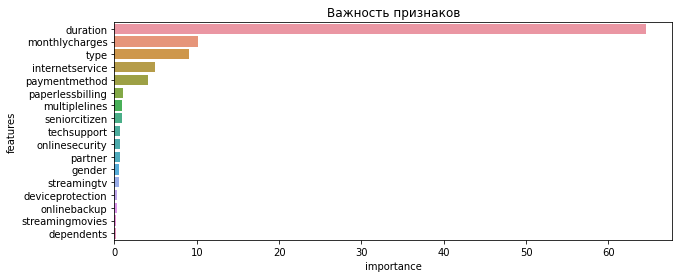

In [82]:
feature_importance = (pd.DataFrame({'features': list(X_train_cbc.columns), 
                                     'importance': estimator_cbc.feature_importances_})
                       .sort_values(by='importance', ascending=False))
plt.figure(figsize=(10, 4));
sns.barplot(x='importance', y='features', data=feature_importance);
plt.title('Важность признаков');

Самым важным признаком у модели является duration, добавленный нами в ходе исследовательского анализа. Не менее важные признаки MonthlyCharges, Type и InternetService.  

Получим предсказания нашей лучшей модели на тестовой выборке и выведем график ROC-AUC.

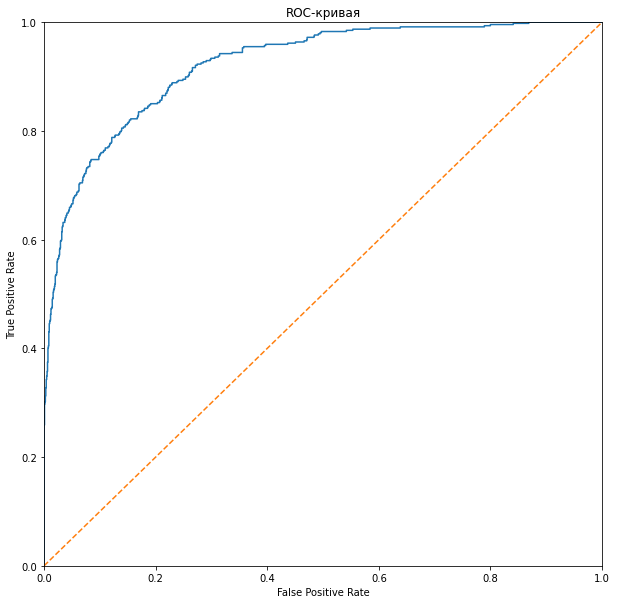

ROC-AUC: 0.9212698039708886


In [83]:
predict = estimator_cbc.predict_proba(X_test_cbc)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_cbc, predict)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_test_cbc, predict))

Метрика на тестовой выборке еще выше. Проверим другие метрики по выбранной модели.

In [84]:
y_bin = (predict >= 0.5)*1
print('Accuracy', accuracy_score(y_test_cbc, y_bin))
print('F1', f1_score(y_test_cbc, y_bin))

Accuracy 0.8739352640545145
F1 0.7369668246445498


### Вывод

In [85]:
model_table = (pd.DataFrame({'model' : model_name,   
                             'best_params': best_params,
                             'ROC-AUC': roc_auc,
                            })
               .sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
              )
model_table['Статус'] = model_table['ROC-AUC'].apply(lambda x:'Метрика достигнута' if x >= 0.85 else 'Метрика не достигнута')
model_table.style.highlight_max(['ROC-AUC'], color='green', axis=0)

,model,best_params,ROC-AUC,Статус
0,CatBoostClassifier CV,"{'learning_rate': 0.1, 'iterations': 600, 'depth': 4}",0.914662,Метрика достигнута
1,LGBMClassifier CV,"{'num_leaves': 128, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}",0.895809,Метрика достигнута
2,RandomForestClassifier CV,"{'n_estimators': 701, 'max_depth': 9}",0.858804,Метрика достигнута


В результате проведенных иследований, получили портрет клиента, которые чаще всего покидают компанию.  
Компанию покидают чаще всего прибыльные пользователи:
- Не имеет иждевенцев
- Холост/не замужем
- Имеет статус пенсионера
- Не пользуется блокировками небезопасных сайтов
- Не имеет выделенной линии поддержки
- Не пользуется облачным хранилищем
- Не использует антивирусное ПО
- Нет разницы по половому признаку
- Пользуется интренет-соединением типа оптоволокно
- Пользуется электронными чеками

Чем выше помесячная оплата, тем выше вероятность ухода. Данные исследования подтвердились также выводами моделей на важности признаков.

По результатам работы быи выполнены все пункты плана работ. 
* Выгрузили данные и дали краткое описание.  
* Выполнили предобработку данных (проверили на пропуски, явные дубли, аномалии, изменили тип данных).  
* Выполнили короткий исследовательский анализ до объединения данных в один датасет.  
* Подготовили данные к обучению: объеденили таблицы в один датасет, обработали пропуски, которые образовались в ходе объединения, провели дополнительный анализ данных, выполнили проверку на мультиколлинеарность, подготовили небольшой Pipeline предобработки для обучения. Создали дополнительный признак `duration`, длительность контракта в днях. Удалили `EndDate` и `BeginDate`, чтобы избежать утечки данных. По показаниям взаимной информации `duration` имеет 0.3п взаимной информации и будет приемлем для обработки. Была обнаружена сильная корреляция между количеством дней и итоговым/накопительным счетом - признак TotalCharges удалили.  
* Обучили три модели: CatBoostClassifier, LGBMClassifier и RandomForestClassifier с подбором гиперпараметров и кросс-валидацией. Выбрали лучшую модель, по которой провели тест, вывели график с ключевой метрикой, так же получили показания по другим метрикам. Изучили важность признаков для модели.

В ходе обучения выяснено, что наиболее важными признаки для лучшей модели стали - duration, MonthleCharges, Type и InternetService.  
Целевой метрикой обозначили ROC-AUC со следующими критериями оценки:  
• 0.85 ≤ AUC-ROC < 0.87 — удовлетворительно  
• 0.87 ≤ AUC-ROC < 0.88 — хорошо  
• AUC-ROC ≥ 0.88 — отлично    
Лучше себя показала модель на базе CatBoost, метрика AUC на тесте достигла 0.92, дополнительно посмотрели метрики:
* F1 0.74, что можно считать неплохим результатом  
* Accuracy  0.87  
Работа осложняется подбором гиперпараметров с помощью RandomizedSearchCV и GridSearchCV, возможно стоит попробовать подбирать гиперпараметры с помощью Optuna. RandomForestClassifier выдал самую плохую метрику из трех моделей, но соответствующую критериям оценки.

## Отчет о проделанной работе

**Цель проекта** – разработать модель прогнозирования оттока клиентов (Churn prediction model). Модель должна быть готова через 2 недели. За это время необходимо провести исследование и разработать самостоятельно модель, написать отчет по исследованию. После этого модель пойдет в Production.

**Описание проекта:**  
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Отдел маркетинга провел исследование и выяснил, что в последнее время из нашей компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

План работы был следующим:

1.  Загрузка данных и описание  
    1.1  Вывод  
2.  Предобработка данных  
    2.1  Проверка на пропуски  
    2.2  Изменение типов данных  
    2.3  Проверка на явные дубликаты  
    2.4  Проверка на аномалии  
    2.5  Вывод  
3.  Исследовательский анализ данных  
4.  Подготовка данных к обучению  
    4.1  Объединение таблиц в единый датасет  
    4.2  Обработка пропусков в новом датасете  
    4.3  Дополнительный анализ данных после объединения таблиц  
    4.4  Проверка на мультиколлинеарность  
    4.5  Pipeline предобработки  
    4.6  Вывод  
5.  Обучение моделей  
    5.1  CatBoostClassifier  
    5.2  LGBMClassifier  
    5.3  RandomForestClassifier  
    5.4  Выбор лучшей модели и ее тестирование  
6.  Отчет по результатам анализа

### Какие пункты плана были выполнены, а какие — нет?

По результатам работы быи выполнены все пункты плана работ. 
1. Выгрузили данные и дали краткое описание.  
2. Выполнили предобработку данных (проверили на пропуски, явные дубли, аномалии, изменили тип данных).  
3. Выполнили короткий исследовательский анализ до объединения данных в один датасет.  
4. Подготовили данные к обучению: объеденили таблицы в один датасет, обработали пропуски, которые образовались в ходе объединения, провели дополнительный анализ данных, выполнили проверку на мультиколлинеарность, подготовили небольшой Pipeline предобработки для обучения. Создали дополнительный признак `duration`, длительность контракта в днях. Удалили `EndDate` и `BeginDate`, чтобы избежать утечки данных. По показаниям взаимной информации `duration` имеет 0.3п взаимной информации и будет приемлем для обработки. Была обнаружена сильная корреляция между количеством дней и итоговым/накопительным счетом - признак TotalCharges удалили.  
5. Обучили три модели: CatBoostClassifier, LGBMClassifier и RandomForestClassifier с подбором гиперпараметров и кросс-валидацией. Выбрали лучшую модель, по которой провели тест, вывели график с ключевой метрикой, так же получили показания по другим метрикам. Изучили важность признаков для модели.

### Какие трудности возникли и как их преодолели?

Работа осложнялась подбором гиперпараметров, т.к. на это расходуется много времени, начинали подбор с помощью с помощью GridSearchCV, но он мог занимать сутки, поэтому было принято решение использовать RandomizedSearchCV. Возможно стоит попробовать подбирать гиперпараметры с помощью Optuna, она отрабаывает быстрее.

### Какие ключевые шаги в решении задачи выделили?

Ключевыми шагами в работе являлись:  
* *Предобработка данных.* После объединения было много пропусков в данных, сам датасет был небольшой ~ 7000 записей и удалять пропуски было бы нерациональным решением. Так же было важно добавить целевой признак target - факт ухода клиента из компании и признак duration - длительность контракта в днях и удалить признаки EndDate и BeginDate, чтобы избежать утечки данных.  
* *Проверка на мультиколлинеарность.* Данный шаг является важным, если будут использовать линейные модели. В нашей работе линейные модели не применялись, но данный пункт мы выполнили и по результатам удалили признак TotalCharges, т.к. была обнаружена сильная корреляция с duration.  
* *Обучение моделей*. Необходимо уделить достаточное время для подбора гиперпараметров моделей, т.к. достигнутые метрики в нашей проекте скорее всего не являются пределом.Обязательно фиксировать полученные метрики по каждй модели для выбора лучшей в дальнейшем.
* *Выбор лучшей модели и ее тестирование.* Проведение анализа важности факторов с помощью команды feature_importances_. График рейтинга факторов по силе влияния на целевой признака отражает, что часть факторов слабозначимые для модели и оказывают незначительное влияние на целевой признак, можно убрать из модели признаки: streamingmovies, dependents и посмотреть, какой результат будет достигнут; затем убрать еще пару признаков: onlinebackup и deviceprotection и уже выбрать окончательную форму датасета для обучения с лучшими целевыми метриками. Эти признаки скорее всего не влияют на уход клиента. В ходе обучения выяснено, что наиболее важными признаками для ухода клиента стали - duration, MonthleCharges, Type и InternetService.

### Какая итоговая модель и какое у неё качество?

Лучше себя показала модель CatBoostClassifier с гиперпараметрами 'learning_rate'= 0.1, 'iterations'=600, 'depth'=4.  
Метрика AUC на тесте достигла 0.92, дополнительно посмотрели метрики:
* F1 0.74, что можно считать неплохим результатом  
* Accuracy  0.87  

Ниже представлена сравнительная таблица по результатам кросс-валидации моделей:

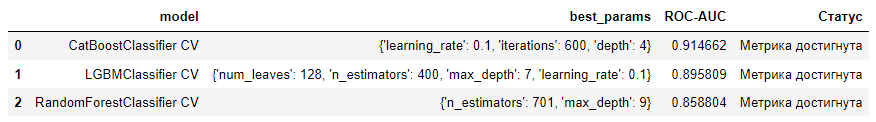